In [104]:
import controllers
import controlpy
import control_utils
import dynamics_models
import numpy as np
import polytope
import system_id
import tqdm
import uncertainty_utils
import experiment_utils

import matplotlib
import matplotlib.pyplot as plt
# matplotlib.rcParams['text.usetex'] = True
plt.rc('font', size=16)
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'large'

## SETUP

In [293]:
# Dynamics Parameters
n_states = 4
n_inputs = 2
dt = 0.1
init_state = np.array([-3.5,0, np.pi/2, 0])
linearization_state = np.zeros(n_states)
linearization_input = np.zeros(n_inputs)

# State and Input Constraints
delta_lim = np.pi / 6
a_lim = 0.3
input_limits = polytope.box2poly([[-a_lim, a_lim], [-delta_lim, delta_lim]])
state_limits = polytope.box2poly([[-4,1],[-1,1],[-5 * np.pi, 5 *np.pi],[-0.1,1]])
state_constraints = (state_limits.A, state_limits.b)
input_constraints = (input_limits.A, input_limits.b)
input_bounds = (-np.array([a_lim, delta_lim]), np.array([a_lim, delta_lim]))

# Control Task
Q = np.diag([1, 10, 1, 1]) 
R = np.eye(n_inputs)
stage_cost = lambda x, u: x.T @ Q @ x + u.T @ R @ u

num_init_episodes = 10
init_input_noise_var = 1e-3
init_input_noise = init_input_noise_var * np.eye(n_inputs)
t_inp = uncertainty_utils.calc_t(0.95, n_inputs)
idb = t_inp * np.sqrt(init_input_noise_var)
input_noise_bound = polytope.box2poly([[-idb, idb]] * n_inputs)

# Noise and Disturbances
process_noise_var = 1e-5
process_noise = process_noise_var * np.eye(n_states)
t = uncertainty_utils.calc_t(0.95, n_states)
db = t * np.sqrt(process_noise_var)
disturbance_bound = polytope.box2poly([[-db, db]] * n_states)

# Experiment Details
episode_length = int(10 / dt)
controller_horizon = 5
state_reference = np.zeros(n_states)
num_episodes = 10



# System ID
h = 2
lamb = 1e-2
n_sysid_pts = 500
n_sysid_it = 10

def model_callback(model, controller, episode_length):
    As, Bs, Cs, covs, errors = model.regress_models(controller.x_traj.value.T, controller.u_traj.value.T)
    return As, Bs, Cs, covs, errors

# Save Results
save_dir = "dubin_car_expts/"
save_data = False

# Vehicle
def get_vehicle():
    init_state_noisy = np.random.multivariate_normal(init_state, process_noise)
    vehicle = dynamics_models.DubinCar(init_state_noisy, dt, process_noise, use_ode_integrator=False)
    return vehicle

def sim_traj(vehicle, controller, input_limits, episode_length=episode_length, model=None, model_callback=None, input_noise=None):
    x_traj = [vehicle.x]
    u_traj = []
    
    x_pred_trajs = []
    u_pred_trajs = []
    model_covs = []
    
    slacks = []
    terminal_slacks = []
    
    for _ in tqdm.tqdm(range(episode_length)):
        u_command = controller.solve(x_traj[-1])
        if u_command is None:
            print("controller error at iteration %d" %_)
            print("state:")
            print(x_traj[-1])
            break
        if input_noise is not None: 
            u_noise = np.random.multivariate_normal(np.zeros(input_limits[0].shape), input_noise)
            u_command = u_command + u_noise
        if model is not None:
            As, Bs, Cs, covs, errors = model_callback(model, controller, episode_length)
            controller.set_models(As, Bs, Cs)
            model_covs.append(covs)
        u = np.minimum(np.maximum(input_limits[0], u_command), input_limits[1])
        x_next = vehicle.f(u)

        x_traj.append(x_next)
        u_traj.append(u)
        
        x_pred_trajs.append(controller.x_traj.value.T)
        u_pred_trajs.append(controller.u_traj.value.T)
        
        slacks.append(controller.slack.value)
        terminal_slacks.append(controller.terminal_slack.value)
        
    return np.array(x_traj), np.array(u_traj), x_pred_trajs, u_pred_trajs, slacks, terminal_slacks, model_covs

## Plotting
l = 0.125
w = 0.075
figsize = (8,4)
state_lims_proj = state_limits.project([1,2])

def plot_experiment(traj_list, x_preds, ax, xlims=(-5,2), ylims=(-1.5, 1.5), lw=2, k=10,bbox=(0,0)):
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_xlabel("x in (m)")
    ax.set_ylabel("y in (m)")
    state_lims_proj.plot(ax=ax, alpha=1, color="w", edgecolor="b", linewidth=lw)
    
    for x_traj in traj_list:
        ss = ax.plot(x_traj[0,:], x_traj[1,:], "r--", label="safe set")
        
    for pred in x_preds:
        ps = ax.plot(pred[:,0], pred[:,1], color="tab:blue", linestyle="--", alpha=0.6, label="predictions")
        
    x_traj = traj_list[-1].T
    ts = ax.plot(x_traj[:,0], x_traj[:,1], "k", lw=lw, label="final trajectory")
    patches = [dynamics_models.plot_vehicle(x[:3], l, w, alpha=0.4) for x in np.rollaxis(x_traj[::k,:],0)]
    for patch in patches:
        ax.add_patch(patch)
    handles, labels = ax.get_legend_handles_labels()
    handles, labels = zip(*[(handles[i], labels[i]) for i in [0,-1,-2]])
    handles = list(handles)
    labels = list(labels)
    handles.append(ax.patches[0])
    labels.append("state constraints")
    ax.legend(handles, labels, bbox_to_anchor=bbox)

## Initial Trajectories With Tracking MPC

In [175]:
vehicle = get_vehicle()
A, B, C = vehicle.get_linearization(linearization_state, linearization_input, dt)
A[1,2] = 0.025

init_state_limits = control_utils.pontryagin_difference(state_limits, disturbance_bound)
init_input_limits = control_utils.pontryagin_difference(input_limits, input_noise_bound)
init_state_constraints = (init_state_limits.A, init_state_limits.b)
init_input_constraints = (init_input_limits.A, init_input_limits.b)

controller = controllers.LTI_MPC_Tracker(A, B, C,
                                         controller_horizon * 2, 
                                         Q, 3*R, state_reference, 
                                         init_state_constraints, init_input_constraints)
controller.build()

In [176]:
x_init_trajs = []
u_init_trajs = []
for _ in range(num_init_episodes):
    vehicle = get_vehicle()
    x_init_traj, u_init_traj, x_init_preds, u_init_preds, slacks, terminal_slacks, model_covs = sim_traj(vehicle, controller, input_bounds, input_noise=init_input_noise)
    x_init_trajs.append(x_init_traj)
    u_init_trajs.append(u_init_traj)
init_value_functions = [control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, stage_cost) for x_traj, u_traj in zip(x_init_trajs, u_init_trajs)]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.29it/s]


[724.1772973183911, 738.7308396821644, 733.3249477423741, 759.5010075717959, 742.0919707680812, 747.8351618291837, 713.2178758020767, 720.3805523604011, 760.1929970726051, 739.9678538943934]


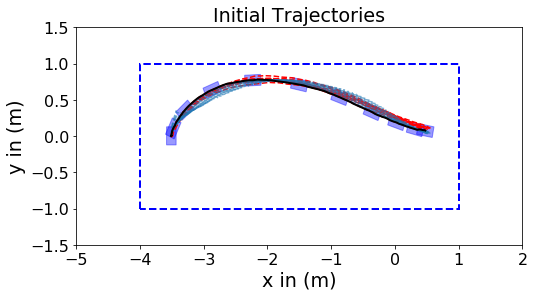

In [177]:
plt.figure(figsize=figsize)
ax = plt.gca()
init_trajs = [x.T for x in x_init_trajs]
plot_experiment(init_trajs, x_init_preds, ax)
plt.title("Initial Trajectories")
print([q[0] for q in init_value_functions])

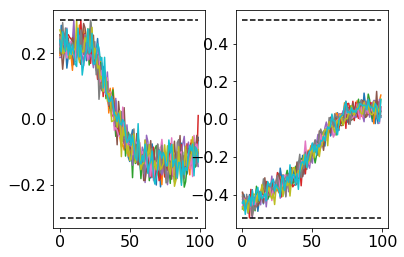

In [178]:
fig, ax = plt.subplots(1,2)
for u_traj in u_init_trajs:
    ax[0].plot(u_traj[:,0])
    ax[1].plot(u_traj[:,1])
for i, lim in enumerate((a_lim, delta_lim)):
    ax[i].plot([lim] * episode_length, "k--")
    ax[i].plot([-lim] * episode_length, "k--")

In [179]:
u_init_trajs[0].shape

(100, 2)

In [111]:
filename = "tracking_mpc"
if save_data:
    experiment_utils.save_result(save_dir, filename, x_init_trajs, u_init_trajs, None, None, None)

## Learning MPC With Local Linear Regression

In [112]:
controller = controllers.LTV_LMPC(A, B, C,
                                     controller_horizon, 
                                     Q,R, state_reference, 
                                     state_constraints, input_constraints)

for x_init_traj, u_init_traj, init_value_func in zip(x_init_trajs, u_init_trajs, init_value_functions):
    controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, init_value_func)

In [113]:
model = system_id.LocalLinearModel(n_states, n_inputs, h, lamb, n_sysid_pts=n_sysid_pts, n_sysid_it=n_sysid_it)
for x_init_traj, u_init_traj in zip(x_init_trajs, u_init_trajs):
    model.add_trajectory(x_init_traj, u_init_traj)

In [114]:
slack_per_episode = []
term_slack_per_episode = []
model_covs_per_episode = []
x_preds_per_episode = []
for episode in range(num_episodes):
    vehicle = get_vehicle()
    
    x_traj, u_traj, x_preds, u_preds, slacks, terminal_slacks, model_covs = sim_traj(vehicle, controller, input_bounds, 
                                                                                     model=model, model_callback=model_callback)
    
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, stage_cost)
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)
    model.add_trajectory(x_traj, u_traj)
    
    As, Bs, Cs, covs, errors = model.regress_models(x_traj[:controller.N,:], u_traj[:controller.N,:])
    controller.set_models(As, Bs, Cs)
    
    slack_per_episode.append(slacks)
    term_slack_per_episode.append(terminal_slacks)
    model_covs_per_episode.append(model_covs)
    x_preds_per_episode.append(x_preds)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.23it/s]


Text(0.5,1,'Naive LTV LMPC')

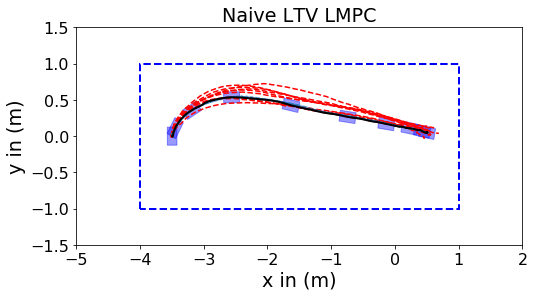

In [115]:
plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment(controller.traj_list[num_init_episodes:], x_preds, ax)
ax.set_title("Naive LTV LMPC")

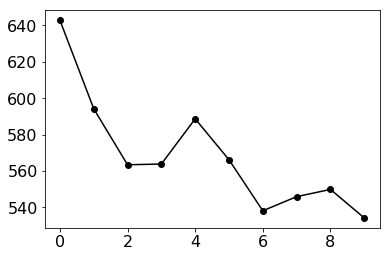

In [116]:
traj_costs = [q[0] for q in controller.value_func_list[num_init_episodes:]]
plt.plot(traj_costs, "k-o")

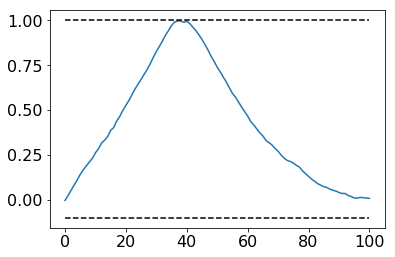

In [117]:
state_vtcs= polytope.extreme(state_limits)
v_max = np.max(state_vtcs[:,-1])
v_min = np.min(state_vtcs[:,-1])
plt.plot(x_traj[:,3])
plt.plot(np.arange(x_traj.shape[0]), np.ones(x_traj.shape[0]) * v_max, "k--")
plt.plot(np.arange(x_traj.shape[0]), np.ones(x_traj.shape[0]) * v_min, "k--")

In [118]:
filename = "naive_ltv_lmpc"
if save_data:
    experiment_utils.save_result(save_dir, filename, controller.traj_list, controller.input_traj_list, x_preds_per_episode, controller.value_func_list, model_covs_per_episode)

## Learning-Based Learning MPC

In [219]:
controller = controllers.LBLMPC(A, B, C,
                                    controller_horizon, 
                                    Q, R, state_reference, 
                                    state_constraints, input_constraints, (disturbance_bound.A, disturbance_bound.b))
## Minimal Invariant Cannot Be Computed
alpha = 2
M = polytope.box2poly([[-db * alpha, db * alpha]] * n_states)
X = polytope.Polytope(*controller.state_constraints)
U = polytope.Polytope(*controller.input_constraints)
X_bar = control_utils.pontryagin_difference(X, M)
U_bar = control_utils.pontryagin_difference(U, control_utils.poly_transform(M, controller.K))
controller.state_constraints = (X_bar.A, X_bar.b)
controller.input_constraints = (U_bar.A, U_bar.b)
controller.init_constraint = (M.A, M.b)

for x_init_traj, u_init_traj, value_function in zip(x_init_trajs, u_init_trajs, init_value_functions):
    x_nominal, u_nominal = control_utils.compute_nominal_traj(x_init_traj.T, u_init_traj.T, A, B, C, controller.K)
    controller.add_trajectory(x_nominal[:,:-1], u_nominal, value_function)

In [220]:
model = system_id.LocalLinearModel(n_states, n_inputs, h, lamb, n_sysid_pts=n_sysid_pts, n_sysid_it=n_sysid_it)
for x_init_traj, u_init_traj in zip(x_init_trajs, u_init_trajs):
    model.add_trajectory(x_init_traj, u_init_traj)

In [221]:
slack_per_episode = []
term_slack_per_episode = []
model_covs_per_episode = []
x_preds_per_episode = []
for episode in range(num_episodes):
    vehicle = get_vehicle()
    x_traj, u_traj, x_preds, u_preds, slacks, terminal_slacks, model_covs = sim_traj(vehicle, controller, input_bounds, 
                                                                                     model=model, model_callback=model_callback)
    
    x_nominal, u_nominal = control_utils.compute_nominal_traj(x_traj.T, u_traj.T, A, B, C, controller.K)
    value_function = control_utils.compute_traj_cost(x_nominal[:,:-1], u_nominal, stage_cost)

    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)
    model.add_trajectory(x_traj, u_traj)
    
    As, Bs, Cs, covs, errors = model.regress_models(x_traj[:controller.N,:], u_traj[:controller.N,:])
    controller.set_models(As, Bs, Cs)
    
    slack_per_episode.append(slacks)
    term_slack_per_episode.append(terminal_slacks)
    model_covs_per_episode.append(model_covs)
    x_preds_per_episode.append(x_preds)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.92it/s]


Text(0.5,1,'LBLMPC')

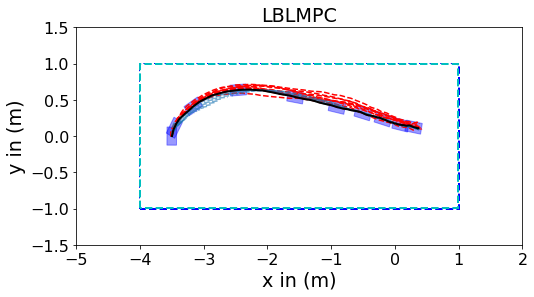

In [222]:
plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment(controller.traj_list[num_init_episodes:], x_preds, ax)
constraint_tight = X_bar.project([1,2])
constraint_tight.plot(ax=ax, alpha=1, color="w", edgecolor="c", linewidth=2)
ax.set_title("LBLMPC")

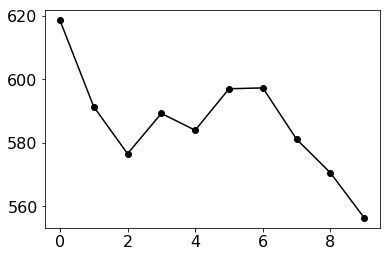

In [224]:
traj_costs = [q[0] for q in controller.value_func_list[num_init_episodes:]]
plt.plot(traj_costs, "k-o")

In [124]:
filename = "lblmpc"
if save_data:
    experiment_utils.save_result(save_dir, filename, controller.traj_list, controller.input_traj_list, x_preds_per_episode, controller.value_func_list, model_covs_per_episode)

### LTV LMPC with Local Safe Sets

In [125]:
safe_set_size = 30
n_safe_set_it = 3
controller = controllers.Local_LTV_LMPC(A, B, C,
                                     controller_horizon, 
                                     Q, R, state_reference, 
                                     state_constraints, input_constraints, n_safe_set_it, safe_set_size)
controller.build()
for x_init_traj, u_init_traj, value_function in zip(x_init_trajs, u_init_trajs, init_value_functions):
    controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, value_function)

In [126]:
model = system_id.LocalLinearModel(n_states, n_inputs, h, lamb, n_sysid_pts=n_sysid_pts, n_sysid_it=n_sysid_it)
for x_init_traj, u_init_traj in zip(x_init_trajs, u_init_trajs):
    model.add_trajectory(x_init_traj, u_init_traj)

In [127]:
slack_per_episode = []
term_slack_per_episode = []
model_covs_per_episode = []
x_preds_per_episode = []
for episode in range(num_episodes):
    vehicle = get_vehicle()
    
    x_traj, u_traj, x_preds, u_preds, slacks, terminal_slacks, model_covs = sim_traj(vehicle, controller, input_bounds, 
                                                                                     model=model, model_callback=model_callback)
    
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, stage_cost)
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)
    model.add_trajectory(x_traj, u_traj)
    
    As, Bs, Cs, covs, errors = model.regress_models(x_traj[:controller.N,:], u_traj[:controller.N,:])
    controller.set_models(As, Bs, Cs)
    
    slack_per_episode.append(slacks)
    term_slack_per_episode.append(terminal_slacks)
    model_covs_per_episode.append(model_covs)
    x_preds_per_episode.append(x_preds)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.46it/s]


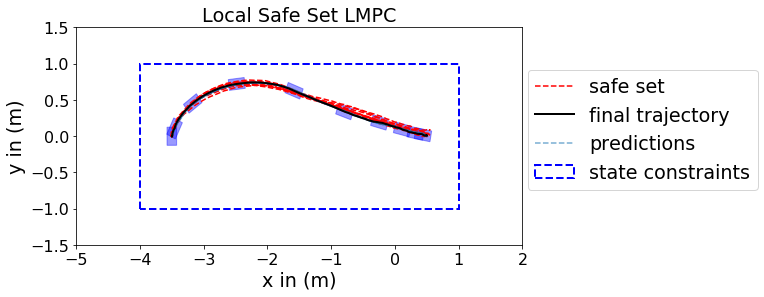

In [303]:
plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment(controller.traj_list[num_init_episodes:], x_preds, ax, bbox= (0.99,0.85))
ax.set_title("Local Safe Set LMPC")
plt.savefig("local_ltv_lmpc_trajs.png", bbox_inches="tight")

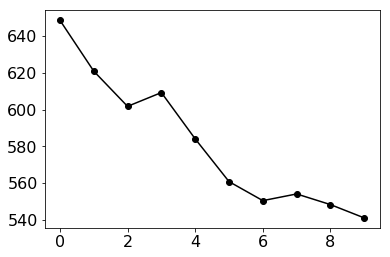

In [129]:
traj_costs = [q[0] for q in controller.value_func_list[num_init_episodes:]]
plt.plot(traj_costs, "k-o")

In [130]:
filename = "local_ltv_lmpc"
if save_data:
    experiment_utils.save_result(save_dir, filename, controller.traj_list, controller.input_traj_list, x_preds_per_episode, controller.value_func_list, model_covs_per_episode)

## True LTV LMPC with Loc Lin Reg

In [156]:
controller = controllers.True_LTV_LMPC(A, B, C,
                                     controller_horizon, 
                                     Q, R, state_reference, 
                                     state_constraints, input_constraints)
for x_init_traj, u_init_traj, value_function in zip(x_init_trajs, u_init_trajs, init_value_functions):
    controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, value_function)

In [157]:
model = system_id.LocalLinearModel(n_states, n_inputs, h, lamb,  n_sysid_pts=n_sysid_pts, n_sysid_it=n_sysid_it)
for x_init_traj, u_init_traj in zip(x_init_trajs, u_init_trajs):
    model.add_trajectory(x_init_traj, u_init_traj)
    
def ltv_model_callback(vehicle, controller, episode_length):
    i = controller.i
    N = controller.N
    i = min(episode_length - N, i)
    x_traj = controller.traj_list[-1][:,i:i+N]
    u_traj = controller.input_traj_list[-1][:,i:i+N]
    As, Bs, Cs, covs, errors = model.regress_models(controller.x_traj.value.T, controller.u_traj.value.T)
    return As, Bs, Cs, covs, errors

In [158]:
slack_per_episode = []
term_slack_per_episode = []
model_covs_per_episode = []
x_preds_per_episode = []
for episode in range(num_episodes):
    vehicle = get_vehicle()
    
    x_traj, u_traj, x_preds, u_preds, slacks, terminal_slacks, model_covs = sim_traj(vehicle, controller, input_bounds, 
                                                                                     model=model, model_callback=ltv_model_callback)
    
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, stage_cost)
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)
    model.add_trajectory(x_traj, u_traj)
    
    As, Bs, Cs, covs, errors = model.regress_models(x_traj[:controller.N,:], u_traj[:controller.N,:])
    controller.set_models(As, Bs, Cs)
    
    slack_per_episode.append(slacks)
    term_slack_per_episode.append(terminal_slacks)
    model_covs_per_episode.append(model_covs)
    x_preds_per_episode.append(x_preds)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.13it/s]


Text(0.5,1,'True TV LMPC')

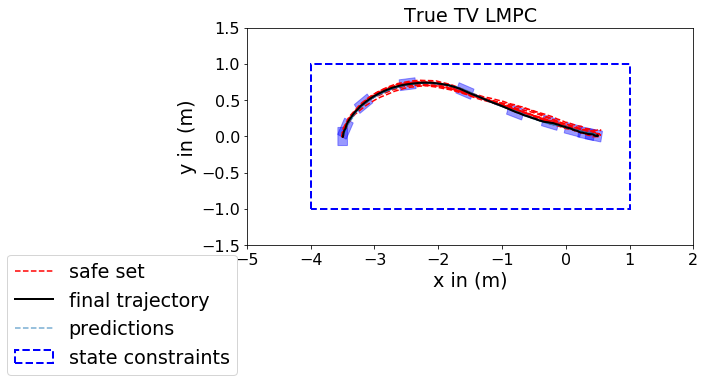

In [294]:
plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment(controller.traj_list[num_init_episodes:], x_preds, ax)
ax.set_title("True TV LMPC")

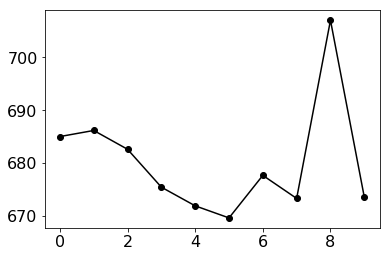

In [160]:
traj_costs = [q[0] for q in controller.value_func_list[num_init_episodes:]]
plt.plot(traj_costs, "k-o" )

In [136]:
filename = "true_ltv_lmpc"
if save_data:
    experiment_utils.save_result(save_dir, filename, controller.traj_list, controller.input_traj_list, x_preds_per_episode, controller.value_func_list, model_covs_per_episode)

## LTI LMPC

In [137]:
controller = controllers.LTI_LMPC(A, B, C,
                                     controller_horizon, 
                                     Q, R, state_reference, 
                                     state_constraints, input_constraints)
for x_init_traj, u_init_traj, value_function in zip(x_init_trajs, u_init_trajs, init_value_functions):
    controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, value_function)

In [138]:
slack_per_episode = []
term_slack_per_episode = []
x_preds_per_episode = []
for episode in range(num_episodes):
    vehicle = get_vehicle()
    x_traj, u_traj, x_preds, u_preds, slacks, terminal_slacks, model_covs = sim_traj(vehicle, controller, input_bounds)
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, stage_cost)
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)
    slack_per_episode.append(slacks)
    term_slack_per_episode.append(terminal_slacks)
    x_preds_per_episode.append(x_preds)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.38it/s]


Text(0.5,1,'LTI LMPC')

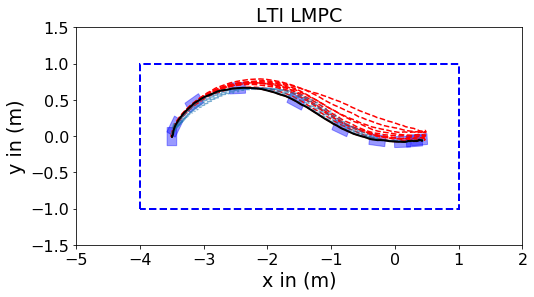

In [139]:
plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment(controller.traj_list[num_init_episodes:], x_preds, ax)
ax.set_title("LTI LMPC")

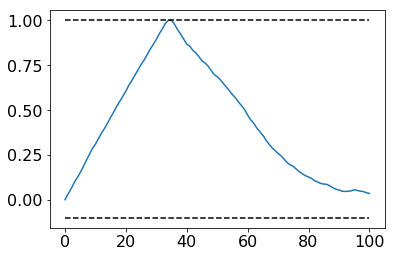

In [140]:
state_vtcs= polytope.extreme(state_limits)
v_max = np.max(state_vtcs[:,-1])
v_min = np.min(state_vtcs[:,-1])
plt.plot(x_traj[:,3])
plt.plot(np.arange(x_traj.shape[0]), np.ones(x_traj.shape[0]) * v_max, "k--")
plt.plot(np.arange(x_traj.shape[0]), np.ones(x_traj.shape[0]) * v_min, "k--")

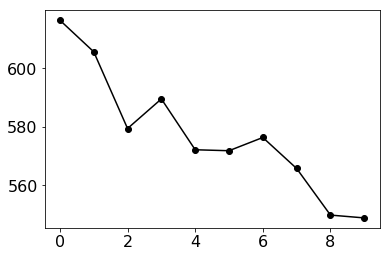

In [141]:
traj_costs = [q[0] for q in controller.value_func_list[num_init_episodes:]]
plt.plot(traj_costs, "k-o" )

In [142]:
filename = "lti_lmpc"
if save_data:
    experiment_utils.save_result(save_dir, filename, controller.traj_list, controller.input_traj_list, x_preds_per_episode, controller.value_func_list, None)

## LTV Tube LMPC

In [264]:
## Minimal Invariant Cannot Be Computed
alpha = 4
M = polytope.box2poly([[-db * alpha, db * alpha]] * n_states)
minimal_invariant = (M.A, M.b)

controller = controllers.LTV_Tube_LMPC(A, B, C,
                                    controller_horizon, 
                                    Q, R, state_reference, 
                                    state_constraints, input_constraints, minimal_invariant)

for x_init_traj, u_init_traj, value_function in zip(x_init_trajs, u_init_trajs, init_value_functions):
    controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, value_function)

In [265]:
model = system_id.LocalLinearModel(n_states, n_inputs, h, lamb, n_sysid_pts=n_sysid_pts, n_sysid_it=n_sysid_it)
for x_init_traj, u_init_traj in zip(x_init_trajs, u_init_trajs):
    model.add_trajectory(x_init_traj, u_init_traj)

In [266]:
slack_per_episode = []
term_slack_per_episode = []
model_covs_per_episode = []
x_preds_per_episode = []
for episode in range(num_episodes):
    vehicle = get_vehicle()
    
    x_traj, u_traj, x_preds, u_preds, slacks, terminal_slacks, model_covs = sim_traj(vehicle, controller, input_bounds, 
                                                                                     model=model, model_callback=model_callback)
    
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, stage_cost)
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)
    model.add_trajectory(x_traj, u_traj)
    
    As, Bs, Cs, covs, errors = model.regress_models(x_traj[:controller.N,:], u_traj[:controller.N,:])
    controller.set_models(As, Bs, Cs)
    
    slack_per_episode.append(slacks)
    term_slack_per_episode.append(terminal_slacks)
    model_covs_per_episode.append(model_covs)
    x_preds_per_episode.append(x_preds)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.52it/s]


Text(0.5,1,'LTV Tube LMPC')

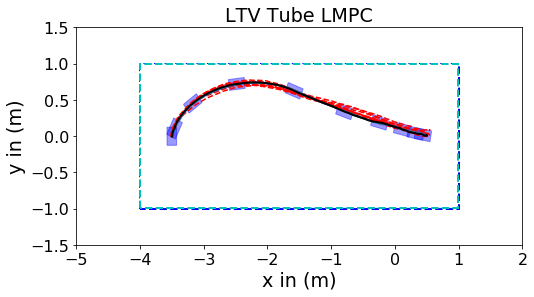

In [267]:
plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment(controller.traj_list[num_init_episodes:], x_preds, ax)
X_bar = polytope.Polytope(*controller.state_constraints)
constraint_tight = X_bar.project([1,2])
constraint_tight.plot(ax=ax, alpha=1, color="w", edgecolor="c", linewidth=2)
ax.set_title("LTV Tube LMPC")

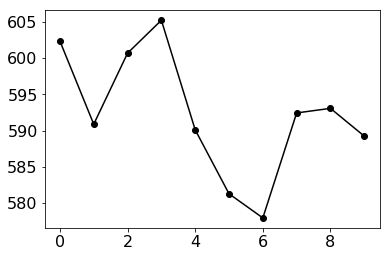

In [268]:
traj_costs = [q[0] for q in controller.value_func_list[num_init_episodes:]]
plt.plot(traj_costs, "k-o" )
# plt.ylim((500,800))

In [148]:
filename = "tube_ltv_lmpc"
if save_data:
    experiment_utils.save_result(save_dir, filename, controller.traj_list, controller.input_traj_list, x_preds_per_episode, controller.value_func_list, model_covs_per_episode)

In [551]:
import time

4.505680799484253
